# Enron Dataset Analysis
<hr>
**Author:** *Gilberto Diaz*

In [30]:
import pandas as pd
import email
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('enron').getOrCreate()

### Loading enron dataset

In [31]:
data = pd.read_csv('./emails.csv')
data.shape

(517401, 2)

Over half million rows and two columns.

In [32]:
data.columns

Index(['file', 'message'], dtype='object')

In [33]:
for file in data['file'][:20]:
    print(file)

allen-p/_sent_mail/1.
allen-p/_sent_mail/10.
allen-p/_sent_mail/100.
allen-p/_sent_mail/1000.
allen-p/_sent_mail/1001.
allen-p/_sent_mail/1002.
allen-p/_sent_mail/1003.
allen-p/_sent_mail/1004.
allen-p/_sent_mail/101.
allen-p/_sent_mail/102.
allen-p/_sent_mail/103.
allen-p/_sent_mail/104.
allen-p/_sent_mail/105.
allen-p/_sent_mail/106.
allen-p/_sent_mail/107.
allen-p/_sent_mail/108.
allen-p/_sent_mail/109.
allen-p/_sent_mail/11.
allen-p/_sent_mail/110.
allen-p/_sent_mail/111.


For now, I don't see how this data is useful. Probably, if the numbers are some sort of a sequence we can compare with dates to verify veracity or data manipulation.

In [34]:
for key, message in enumerate(data['message'][:10]):
    print(f'{key} => {message}')
    print('=========================================\n')

0 => Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 

1 => Message-ID: <15464986.1075855378456.JavaMail.evans@thyme>
Date: Fri, 4 May 2001 13:51:00 -0700 (PDT)
From: phillip.allen@enron.com
To: john.lavorato@enron.com
Subject: Re:
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: John J Lavorato <John J Lavorato/ENRON@enronXgate@ENRON>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Travel

The value on each iteration is the entire email.

In [35]:
type(data['message'][0])

str

Full email content is a string.

Looks like the message has the [RFC822](https://www.w3.org/Protocols/rfc822/) message protocol. Researching in [Kaggle](http://www.kaggle.com) the Enron dataset I found that [Python](http://www.python.org) has a library to parse messages in RFC822 format and the documentation is [here](https://docs.python.org/3.4/library/email.message.html#email.message.Message.walk). Since the `message` column has the most useful content, lets start parsing that column.

Parsing the string into an email object - documentation [here](https://docs.python.org/3.4/library/email.parser.html?highlight=message_from_string#email.message_from_string).

In [36]:
emails = list(map(email.message_from_string, data['message']))

In [37]:
print(len(emails))
emails[0]

517401


Now I have each row in a email object.

### Transforming email object into data frame.

In [38]:
print(emails[0])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


The email parser would take each row header as key (`Message-ID`, `Date`, `From`, `To`, etc). We are going to use those keys to iterate over each row object and extract the data. Each key will become column names and the respective values as rows.

In [39]:
emails_key = emails[0].keys()
emails_key

['Message-ID',
 'Date',
 'From',
 'To',
 'Subject',
 'Mime-Version',
 'Content-Type',
 'Content-Transfer-Encoding',
 'X-From',
 'X-To',
 'X-cc',
 'X-bcc',
 'X-Folder',
 'X-Origin',
 'X-FileName']

The actual content of the email doesn't have a key therefore that key is not present in the `list`. We are going to get that content with `get_payload()` method from the email package.

In [40]:
df = pd.DataFrame()
for key in emails_key:
    df[key] = [col_value[key] for col_value in emails]
    df['email_body'] = [email_content.get_payload() for email_content in emails]

In [50]:
df.head()

,Message-ID,email_body,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName
0,<18782981.1075855378110.JavaMail.evans@thyme>,Here is our forecast\n\n,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst
1,<15464986.1075855378456.JavaMail.evans@thyme>,Traveling to have a business meeting takes the...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst
2,<24216240.1075855687451.JavaMail.evans@thyme>,test successful. way to go!!!,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf
3,<13505866.1075863688222.JavaMail.evans@thyme>,"Randy,\n\n Can you send me a schedule of the s...","Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf
4,<30922949.1075863688243.JavaMail.evans@thyme>,Let's shoot for Tuesday at 11:45.,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf


In [51]:
df.drop(['Content-Transfer-Encoding', 'Content-Type', 'Mime-Version'], axis=1, inplace=True)
df.head()

,Message-ID,email_body,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName
0,<18782981.1075855378110.JavaMail.evans@thyme>,Here is our forecast\n\n,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst
1,<15464986.1075855378456.JavaMail.evans@thyme>,Traveling to have a business meeting takes the...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst
2,<24216240.1075855687451.JavaMail.evans@thyme>,test successful. way to go!!!,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf
3,<13505866.1075863688222.JavaMail.evans@thyme>,"Randy,\n\n Can you send me a schedule of the s...","Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf
4,<30922949.1075863688243.JavaMail.evans@thyme>,Let's shoot for Tuesday at 11:45.,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf


In [52]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df.head()

,Message-ID,email_body,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName
0,<18782981.1075855378110.JavaMail.evans@thyme>,Here is our forecast\n\n,2001-05-14 23:39:00,phillip.allen@enron.com,tim.belden@enron.com,,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst
1,<15464986.1075855378456.JavaMail.evans@thyme>,Traveling to have a business meeting takes the...,2001-05-04 20:51:00,phillip.allen@enron.com,john.lavorato@enron.com,Re:,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst
2,<24216240.1075855687451.JavaMail.evans@thyme>,test successful. way to go!!!,2000-10-18 10:00:00,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf
3,<13505866.1075863688222.JavaMail.evans@thyme>,"Randy,\n\n Can you send me a schedule of the s...",2000-10-23 13:13:00,phillip.allen@enron.com,randall.gay@enron.com,,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf
4,<30922949.1075863688243.JavaMail.evans@thyme>,Let's shoot for Tuesday at 11:45.,2000-08-31 12:07:00,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf


In [57]:
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
sb.set()

Text(0,0.5,'# Emails')

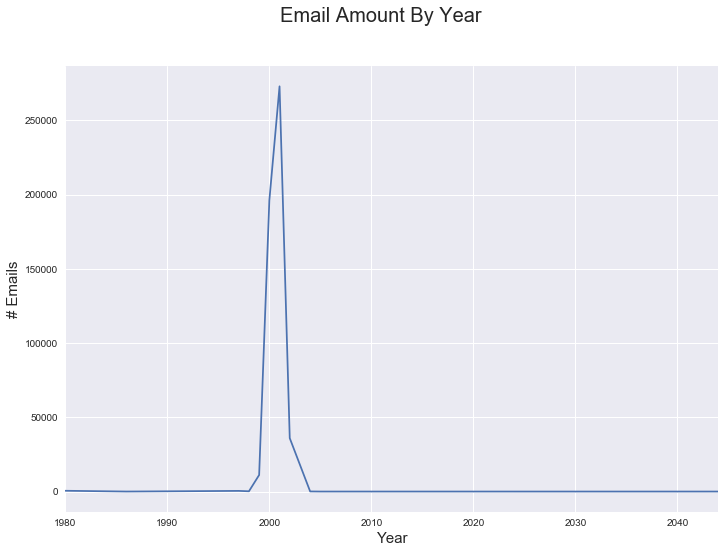

In [61]:
dims = (11.7, 8.2)
fig, ax = plt.subplots(figsize=dims)
ax.figure.suptitle('Email Amount By Year', fontsize=20)
ax = df.groupby(df['Date'].dt.year)['email_body'].count().plot()
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('# Emails', fontsize=15)

It is a spike in the amount of emails around 2001. Based on [this article](http://www.corpwatch.org/article.php?id=2278), that is the time when Enron discloses it has overstated its earnings by $600 million, dating back to 1997.

In [161]:
from_count = df.groupby('X-Origin').agg({
    'From': 'count'
})

from_count.rename(columns={'From': 'From Count'}, inplace=True)
from_count.sort_values('From Count', ascending=False, inplace=True)
from_count.head()

,From Count
X-Origin,
Kaminski-V,26995
DASOVICH-J,26323
KEAN-S,23621
MANN-K,22414
JONES-T,18598


The top 5 amount of email sent by user.

### TODO:
- After getting the to 5 users sending emails, find out what position they have in the company.
- Count the `To` to see if correlates with the `From`.
- Also count the amount of words to see if correlates with the amount of `From`.